### As it is very current, I'm goint to investigate if winning the Oscar has an effect on the ratings. 

In [76]:
import pandas as pd
import re
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the data

In [2]:
cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('latest/ratings.dat', sep='::',
                    index_col=False, names=cols,
                          encoding="UTF-8", engine='python')

In [5]:
cols = ['movie_id', 'movie_title', 'movie_genre']
movies = pd.read_csv('latest/movies.dat', sep='::',
                    index_col=False, names=cols,
                          encoding="UTF-8", engine='python')
movies['title'] = movies['movie_title'].apply(lambda x: x.split('(')[0])
movies['movie_year'] = movies['movie_title'].apply(lambda x: re.findall('\((.*?)\)',x)[0])


In [6]:
joined = ratings.merge(movies, on='movie_id', how='left')

joined['date'] = pd.to_datetime(joined['timestamp'], unit='s')

#### Oscar nominees, winners and the date of the gala for 2013,2014 and 2015

In [90]:
nominees = ['The Big Short (2015)', 'Bridge of Spies (2015)', 'Brooklyn (2015)', 'The Martian (2015)', 'The Revenant (2015)', 'Room (2015)',
           'American Sniper (2014)', 'Boyhood (2014)', 'The Grand Budapest Hotel (2014)', 'The Imitation Game (2014)', 'Selma (2014)', 'The Theory of Everything (2014)', 'Whiplash (2014)',
           'American Hustle (2013)', 'Captain Phillips (2013)', 'Dallas Buyers Club (2013)', 'Gravity (2013)', 'Her (2013)', 'Nebraska (2013)', 'Philomena (2013)', 'The Wolf of Wall Street (2013)']

In [91]:
winners = ['Spotlight (2015)', 'Birdman (2014)', '12 Years a Slave (2013)']

In [92]:
oscardates = {'2015':pd.datetime(2016,02,13),
              '2014':pd.datetime(2015,02,07),
              '2013':pd.datetime(2014,03,02)}

In [121]:
oscardates_df = pd.DataFrame(oscardates.items(), columns=['movie_year','oscardate'])

#### For ratings about movies from 2013-2015 signaling if the movie was a nominee, a winner or none and if the rating was made before or after the Oscar gala of the given year

In [124]:
joined_oscar = joined.merge(oscardates_df, on='movie_year', how='left')

In [133]:
joined_oscar['dateFromOscar'] = np.where(joined_oscar['date']<joined_oscar['oscardate'], 'before',
                                        np.where(joined_oscar['date']>joined_oscar['oscardate'], 'after', 'not_oscar_year'))

In [131]:
joined_oscar['oscar']=np.where(joined_oscar['movie_title'].isin(nominees), 'nominee', 
                         np.where(joined_oscar['movie_title'].isin(winners), 'winner', 'no_oscar'))

In [134]:
joined_oscar.groupby(['oscar', 'dateFromOscar']).agg({'rating':{'RatingCount':'count', 'RatingMean':'mean'}})

rating            
                        RatingMean RatingCount
oscar    dateFromOscar                        
no_oscar after            6.948859       79037
         before           7.105612      171231
         not_oscar_year   7.423200      299622
nominee  after            7.975432       11804
         before           8.201367       17118
winner   after            7.917287        2285
         before           8.375799        2033

#### Looks like after the gala all the movies are rated lower. Let's see if the confidence intervals are overlapping or not

In [181]:
# Collecting the means, and the confidence intervals
mean = []
lower = []
upper = []
for x in itertools.product(['winner', 'nominee', 'no_oscar'], ['before','after']):
    a = joined_oscar[(joined_oscar['oscar']==x[0]) & (joined_oscar['dateFromOscar']==x[1])]['rating']
    conf_interval = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    mean.append(np.mean(a))
    lower.append(np.mean(a) - conf_interval[0])
    upper.append(conf_interval[1] - np.mean(a))

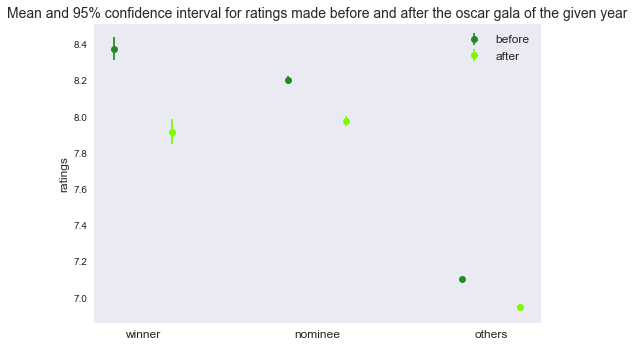

In [233]:
# Making a plot 
sns.set_style("dark")
fig, ax = plt.subplots()
ax.margins(0.05)
ax.errorbar([1,4,7], [mean[index] for index in [0,2,4]],
            yerr=[[lower[index] for index in [0,2,4]],[upper[index] for index in [0,2,4]]], fmt = 'o', label='before', color='forestgreen')
ax.errorbar([2,5,8], [mean[index] for index in [1,3,5]],
            yerr=[[lower[index] for index in [1,3,5]],[upper[index] for index in [1,3,5]]], fmt = 'o', label='after', color='lawngreen')

ax.legend()
labels = ['winner','nominee', 'others']
plt.xticks([1.5,4.5,7.5], labels, fontsize=12)
plt.legend(prop={'size':12})
plt.ylabel('ratings', fontsize=12)
plt.title('Mean and 95% confidence interval for ratings made before and after the oscar gala of the given year', fontsize=14)
plt.show()

#### Ratings are lower after the oscar gala than before for all movies. Probably those who were really interested in the movies have already watched and rated it, while later rating were coming from people who weren't that interested. As people usually interested in the types of movies they like, this can effect the ratings over time.
#### But it's also shown that Oscar winner movies have been rated higher than nominees and other movies even before they won. The same is true for nominee movies against all the other movies. So it looks like that after all the judgement of the Academy and the common people are not that far from each others